calibration1.jpg has been undistorted.


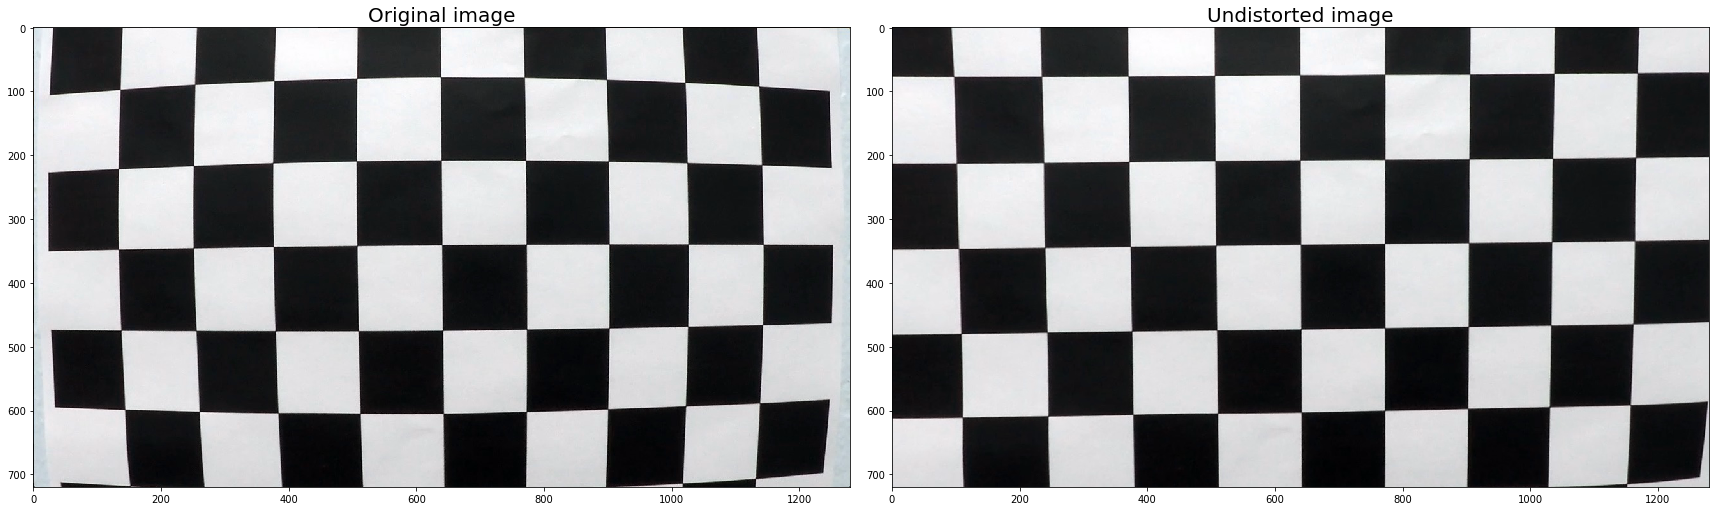

calibration10.jpg seems normal for now.
calibration11.jpg seems normal for now.
calibration12.jpg seems normal for now.
calibration13.jpg seems normal for now.
calibration14.jpg seems normal for now.
calibration15.jpg seems normal for now.
calibration16.jpg seems normal for now.
calibration17.jpg seems normal for now.
calibration18.jpg seems normal for now.
calibration19.jpg seems normal for now.
calibration2.jpg seems normal for now.
calibration20.jpg seems normal for now.
calibration3.jpg seems normal for now.
calibration4.jpg seems normal for now.
calibration5.jpg seems normal for now.
calibration6.jpg seems normal for now.
calibration7.jpg seems normal for now.
calibration8.jpg seems normal for now.
calibration9.jpg seems normal for now.


In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os,sys

## undistortion part
def undistortion(img_name, img):
    dst = img.copy()
    nx = 9 #the number of inside corners in x
    ny = 5 #the number of inside corners in y, there are only 5 corners not 6 in calibration1.jpg
    objpoints = []
    imgpoints = []
    ## prepare object points
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    ## Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ## Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True: # found corners
        ## collect object points and image points, draw corners
        imgpoints.append(corners)
        objpoints.append(objp)
        ## get calibration matrix and coefficients
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
        ## undistort with calibration matrix and coefficients
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        print('%s has been undistorted.' % img_name)
        return True, dst
    else:
        print('%s seems normal for now.' % img_name)
        return False, dst

InputImageDir = 'camera_cal'
OutputImageDir = 'output_images'
InputImages = os.listdir(InputImageDir)
for ii in InputImages:
    image = cv2.imread('%s/%s'% (InputImageDir, ii))
    has_distorted, undistorted = undistortion(ii, image)
    if(has_distorted):
        ## saving
        cv2.imwrite('%s/%s' % (OutputImageDir, ii), undistorted)
        ## plotting
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.set_title('Original image', fontsize=20)
        ax1.imshow(image)
        ax2.set_title('Undistorted image', fontsize=20)
        ax2.imshow(undistorted)
        plt.show()

Image straight_lines1.jpg


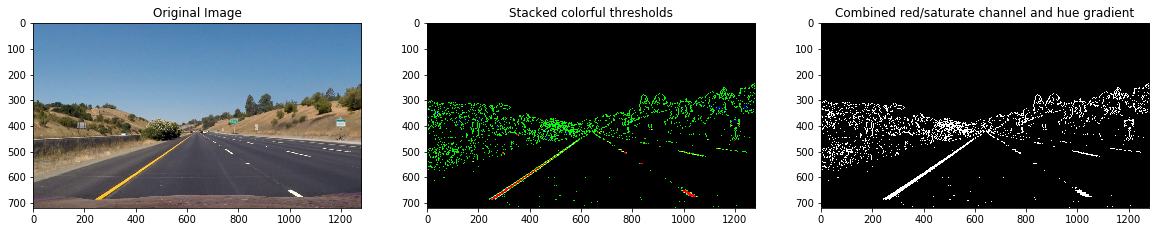

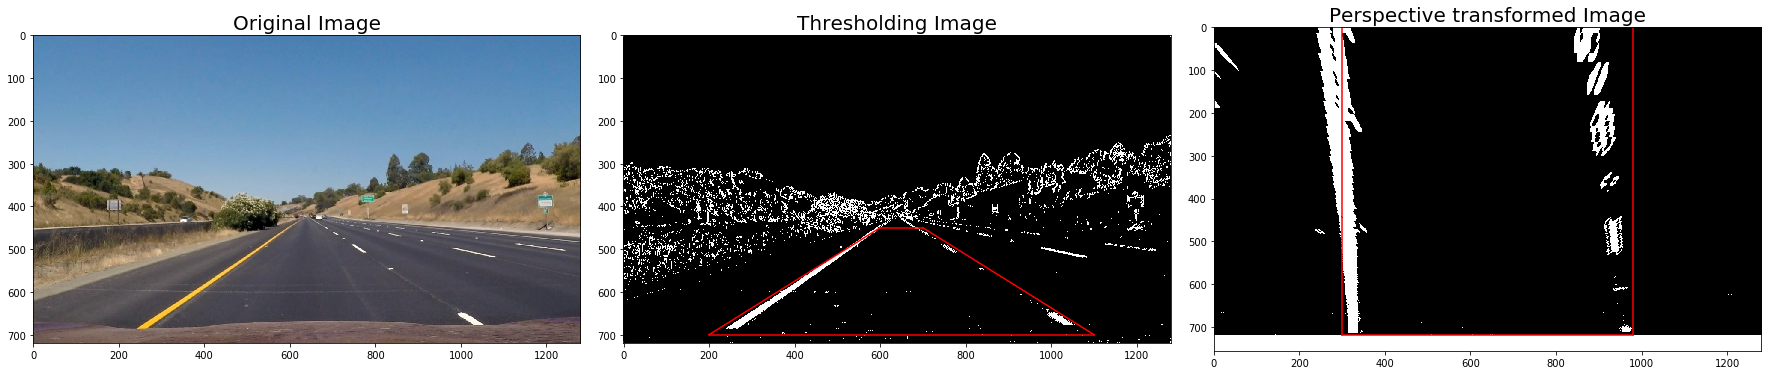

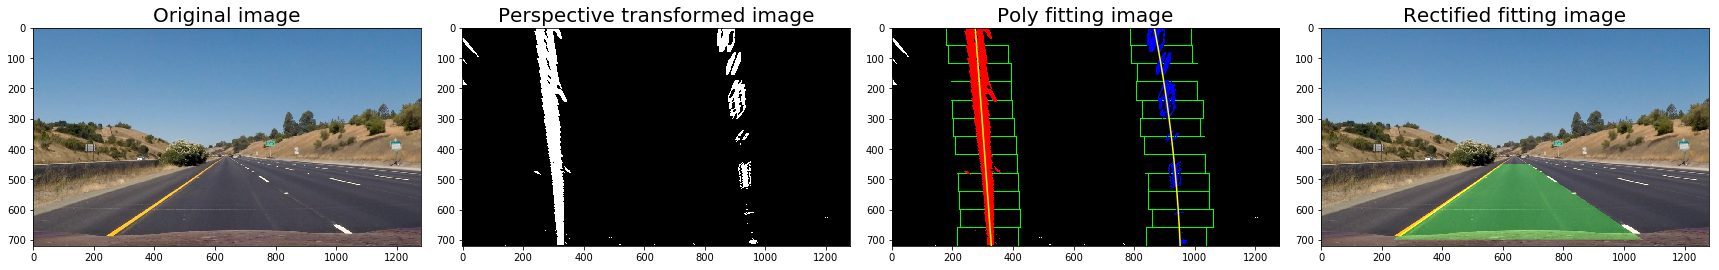

left radius: 62408.2228641, right radius 1552.42413645
Image straight_lines2.jpg


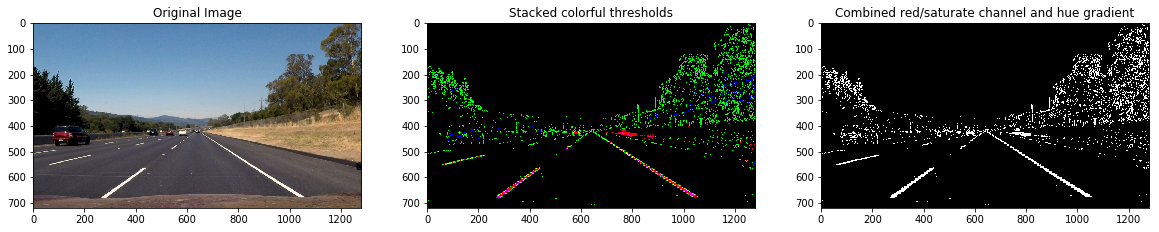

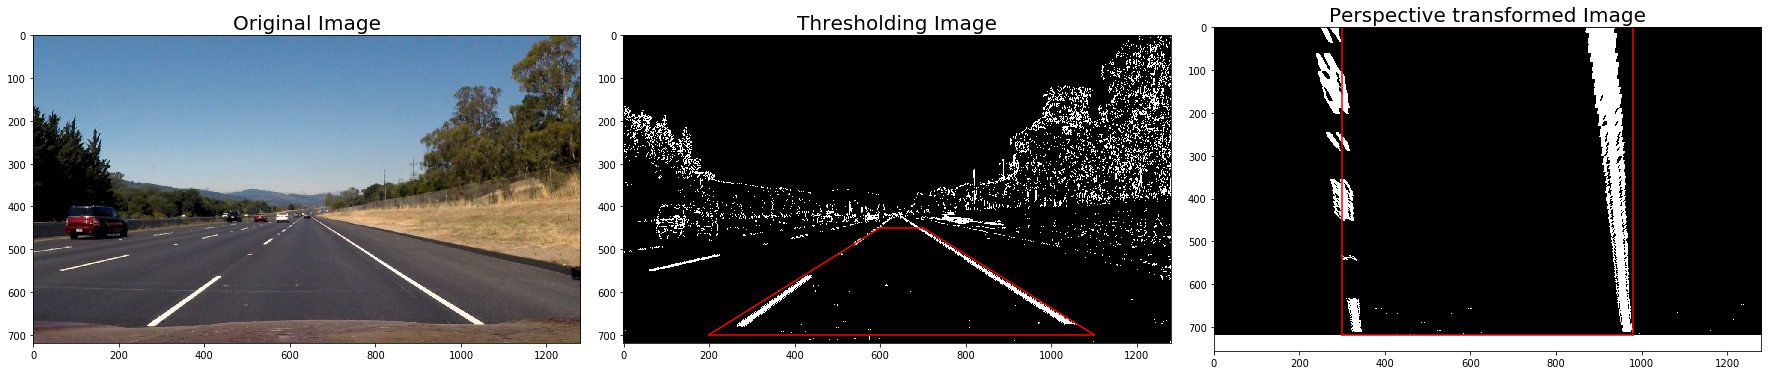

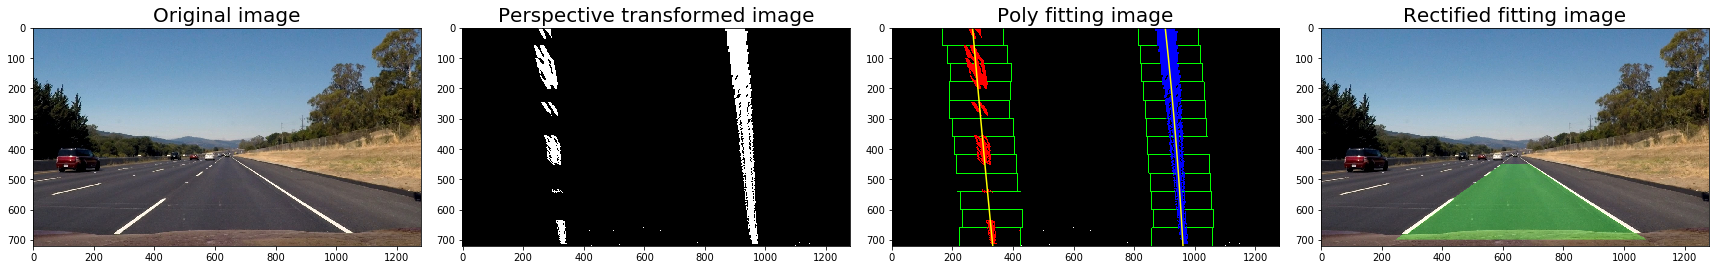

left radius: 20549.2248127, right radius 4385.09583987
Image test1.jpg


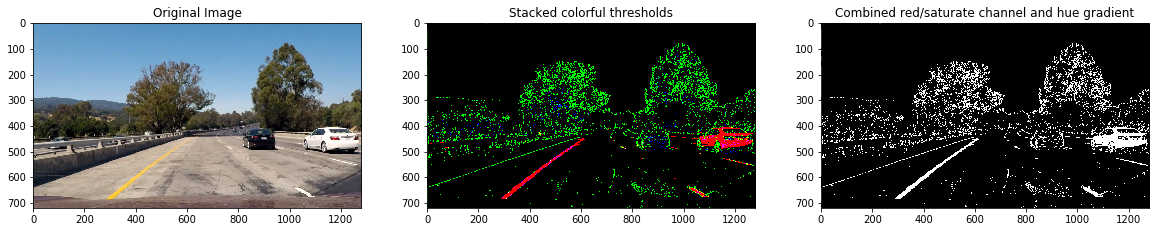

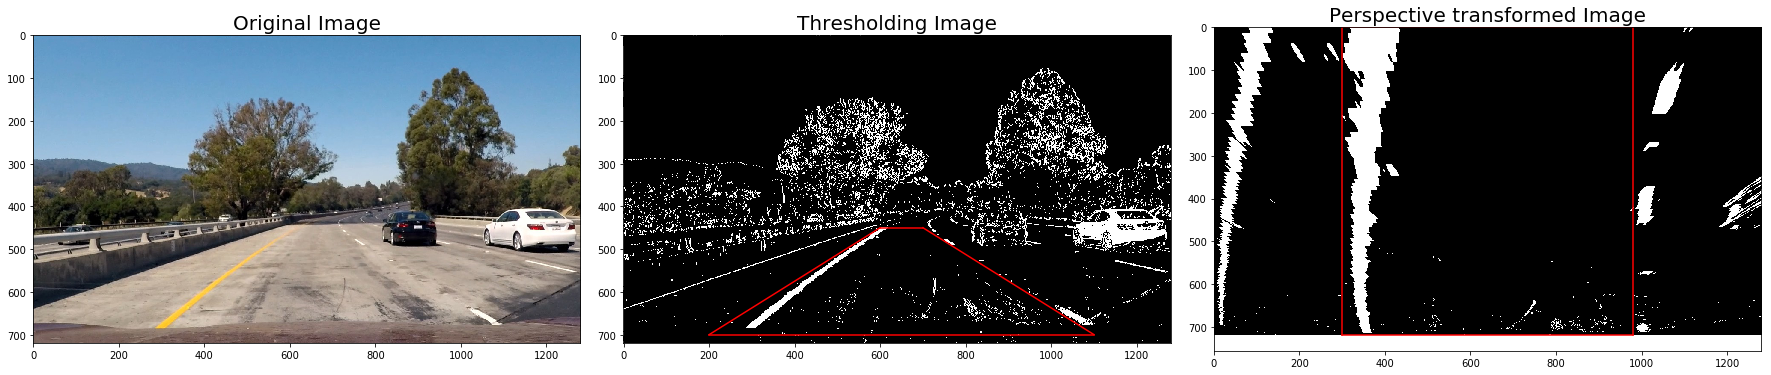

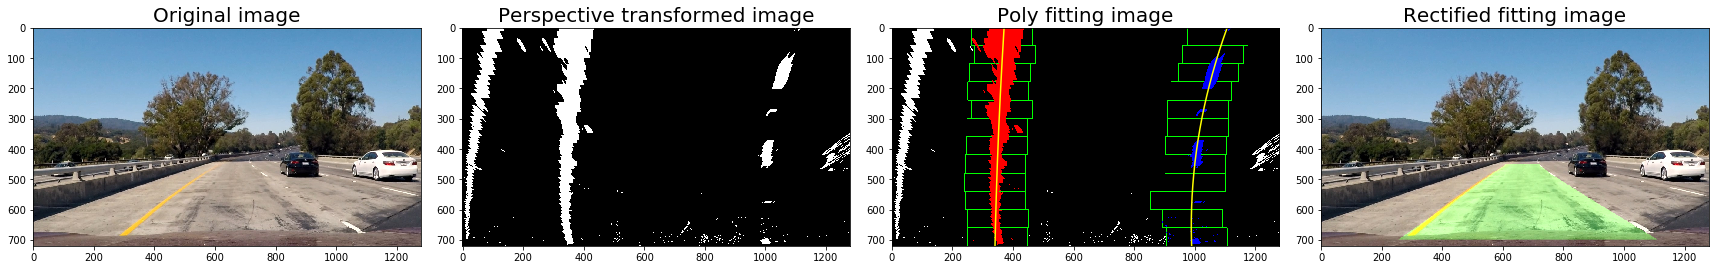

left radius: 5603.08436316, right radius 594.914762462
Image test2.jpg


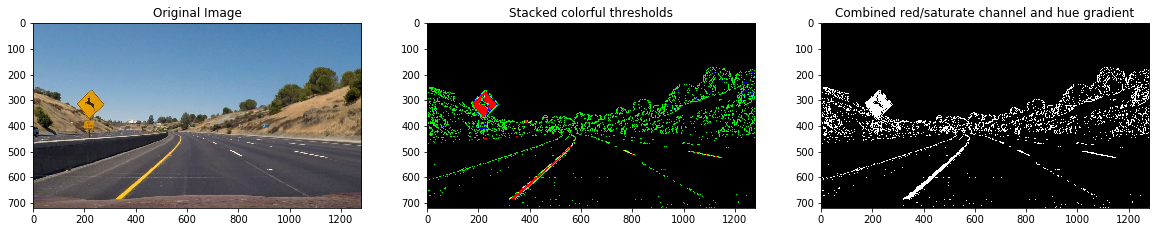

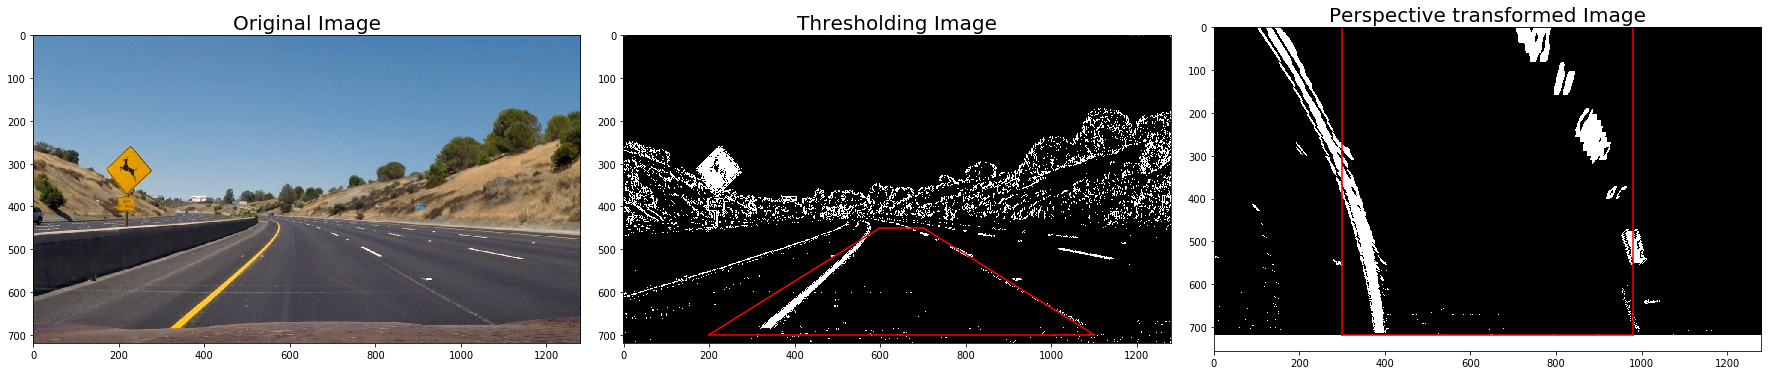

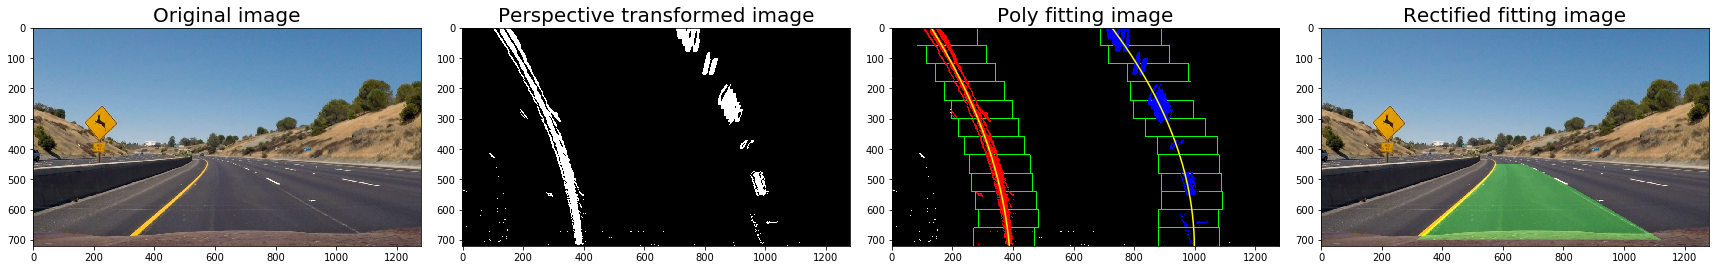

left radius: 442.147696093, right radius 320.148572491
Image test3.jpg


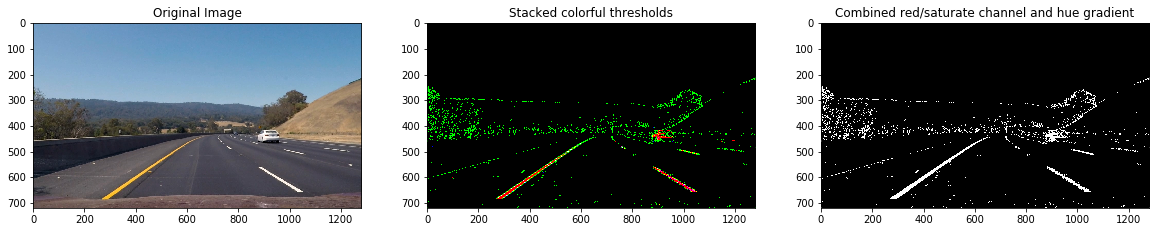

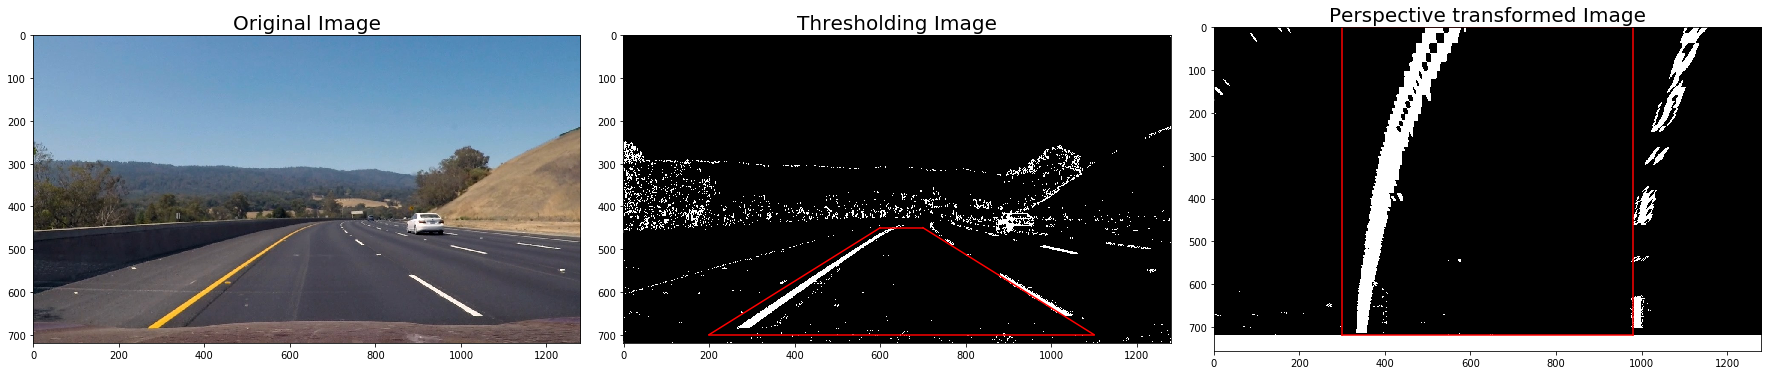

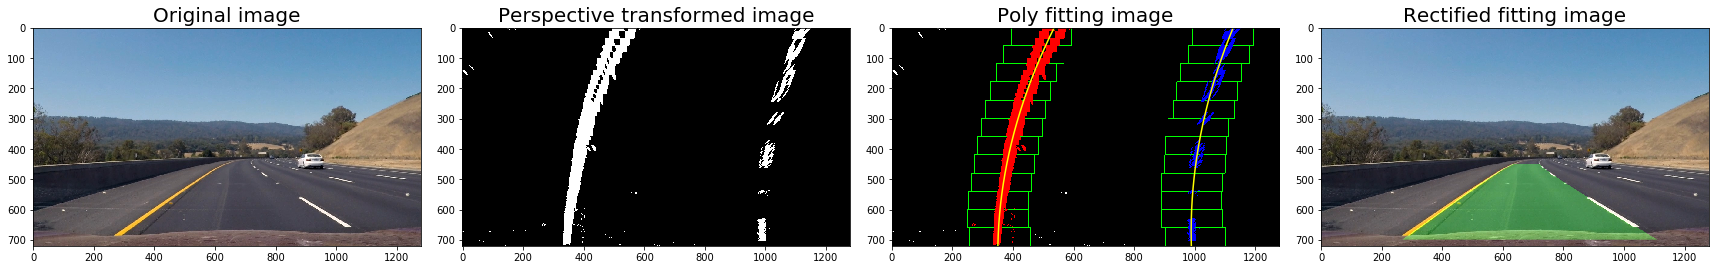

left radius: 495.325031133, right radius 537.126545539
Image test4.jpg


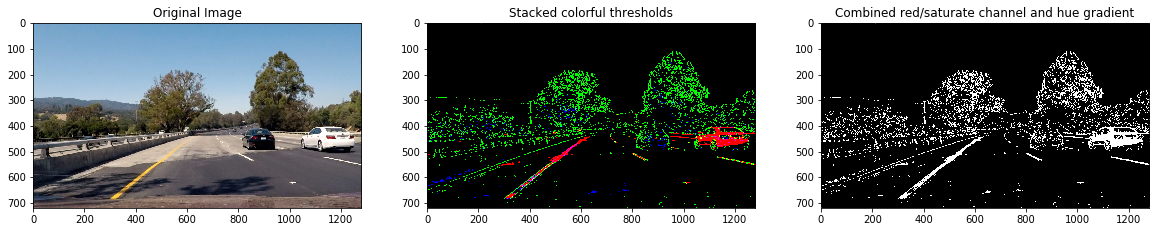

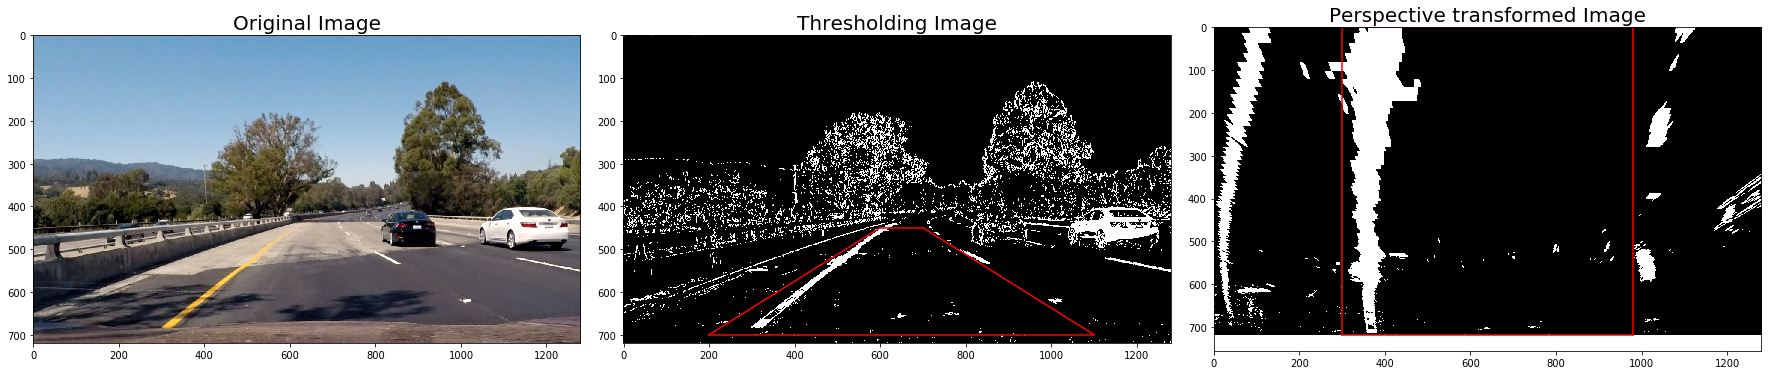

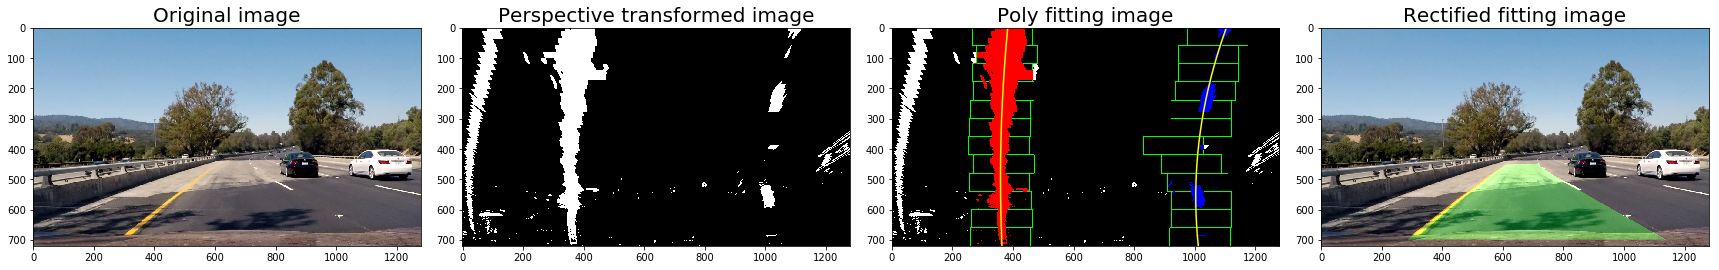

left radius: 1689.892014, right radius 507.217109762
Image test5.jpg


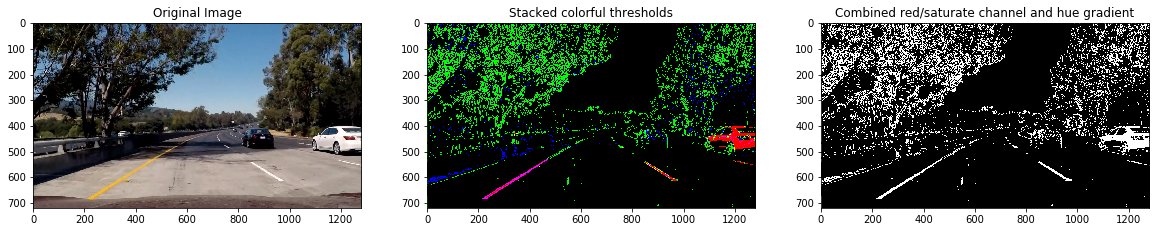

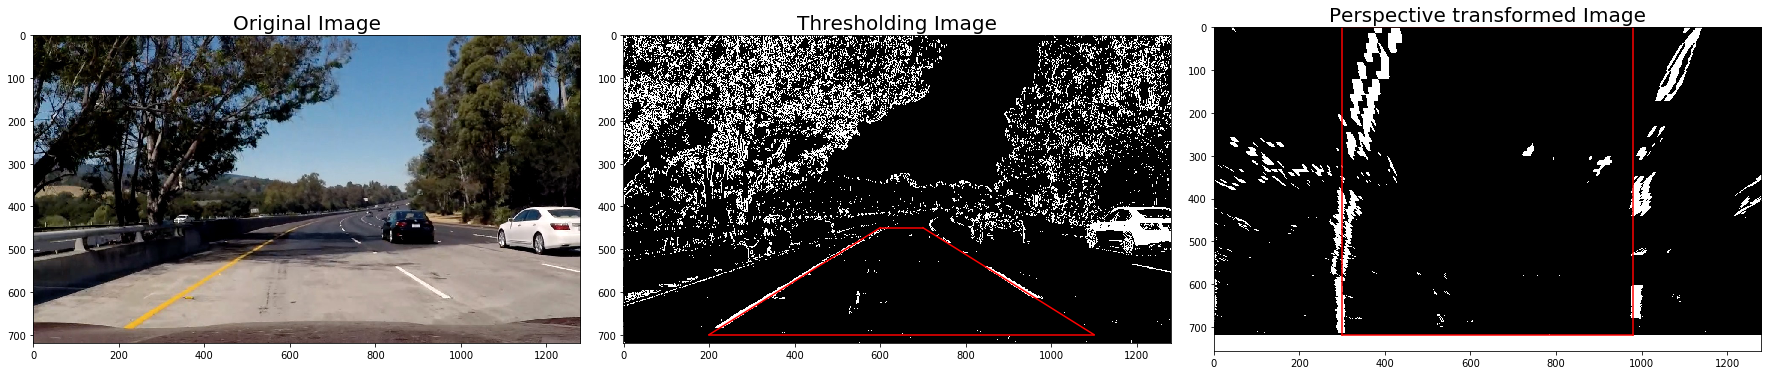

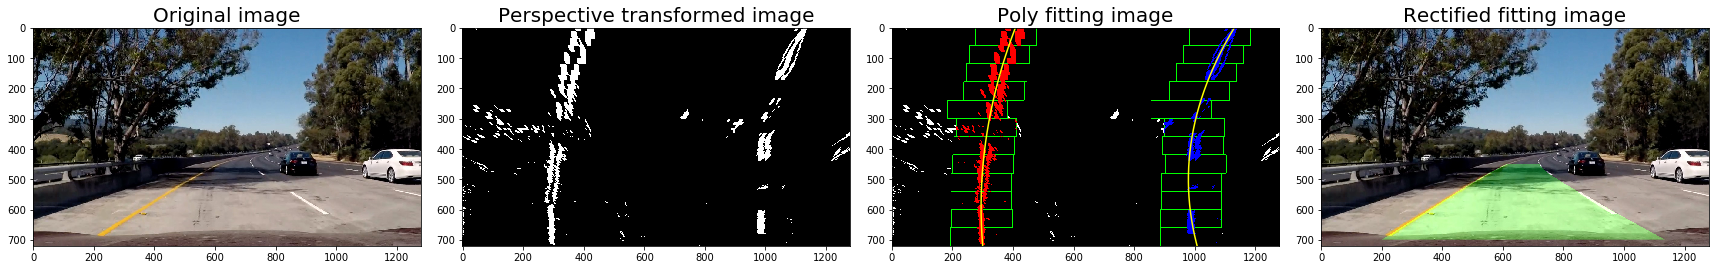

left radius: 510.032860864, right radius 272.98608912
Image test6.jpg


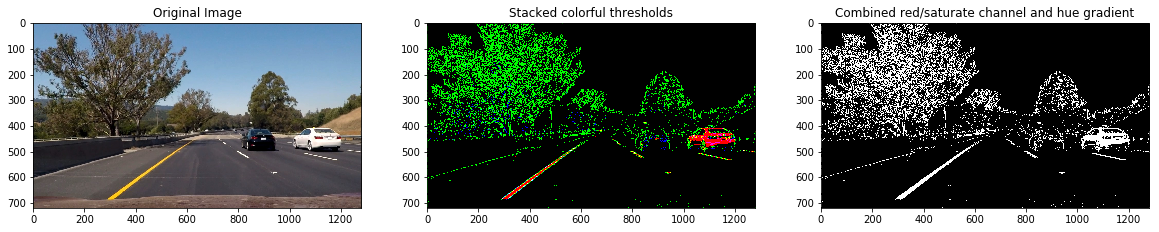

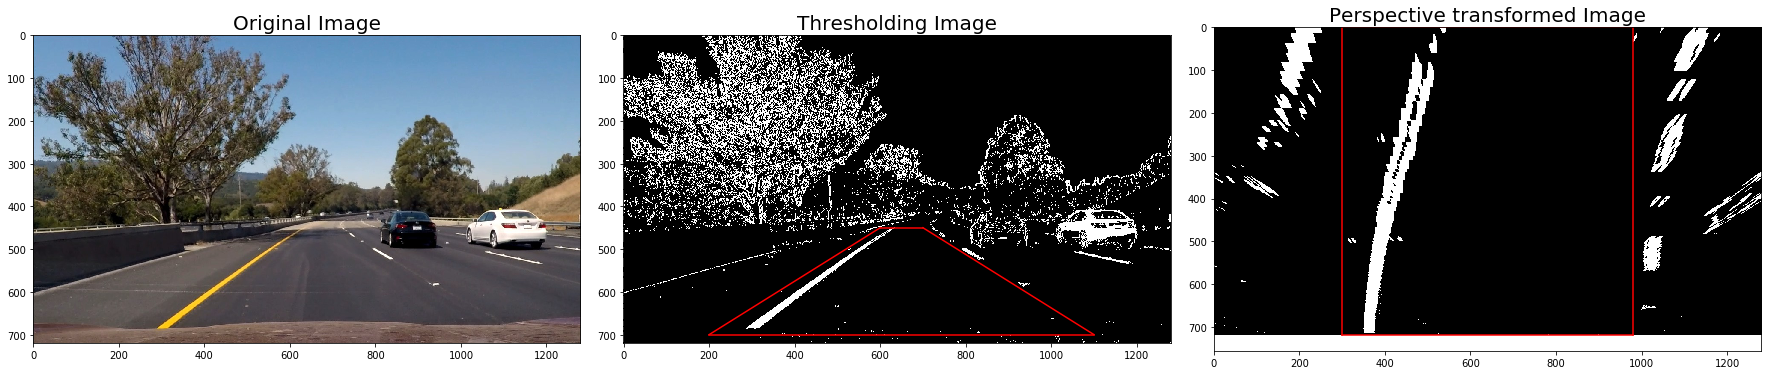

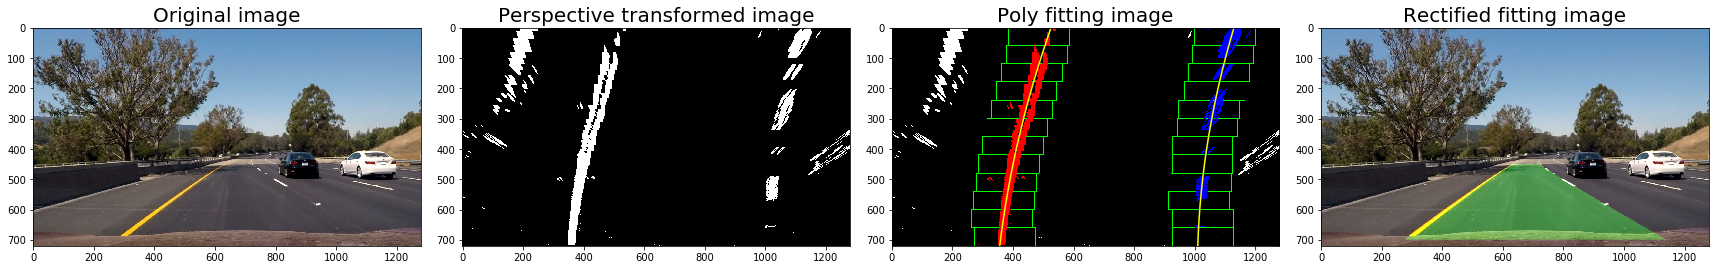

left radius: 1022.98512919, right radius 883.482469395


In [52]:
## pipeline of lane line finding with thresholding, perspective transformation, poly fitting
import matplotlib.image as mpimg

def Threasolding(img, gray_grad_thresh = [20, 100], s_thresh = [170, 220], r_thresh= [220, 255]):
    
    ## Prepare necessary channels
    r_channel = img[:,:,0]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]

    ## Gradient of gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= gray_grad_thresh[0]) & (scaled_sobel <= gray_grad_thresh[1])] = 1

    ## Threshold for S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    ## Thread for R channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( r_binary, sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (r_binary == 1)] = 1
    
    ## Plotting thresholded images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title('Original image')
    ax1.imshow(img)

    ax2.set_title('Stacked colorful image')
    ax2.imshow(color_binary)

    ax3.set_title('Thresholding image')
    ax3.imshow(combined_binary, cmap='gray')
    plt.show()
    
    return color_binary, combined_binary

def PerspectiveTransform(src_img, thresh_img):    
    offset = 300 # offset for dst points
    img_size = (src_img.shape[1], src_img.shape[0])
#     # Source points
#     src_left_top = (440, 550)
#     src_right_top = (870, 550)
    src_left_top = (600, 450)
    src_right_top = (700, 450)
    src_left_bottom = (200, 700)
    src_right_bottom = (1100, 700)
#     src_left_bottom = (350, 600)
#     src_right_bottom = (940, 600)
    dst_left_top = (offset, 0)
    dst_right_top = (img_size[0] - offset, 0)
    dst_right_bottom = (img_size[0]-offset, img_size[1])
    dst_left_bottom = (offset, img_size[1])
    # Perspective tranform operation
    src = np.float32([src_left_top, src_right_top, src_right_bottom, src_left_bottom])
    dst = np.float32([dst_left_top, dst_right_top, dst_right_bottom, dst_left_bottom])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    perspectiveTransformed = cv2.warpPerspective(thresh_img, M, img_size)
    
    ## Plotting
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(src_img, cmap= 'gray')
    
    ax2.set_title('Thresholding Image', fontsize=20)
    ax2.imshow(thresh_img, cmap= 'gray')
    ax2.plot([src_left_top[0], src_left_bottom[0]], [src_left_top[1], src_left_bottom[1]], color = 'r')
    ax2.plot([src_left_top[0], src_right_top[0]], [src_left_top[1], src_right_top[1]], color= 'r')
    ax2.plot([src_right_top[0], src_right_bottom[0]], [src_right_top[1], src_right_bottom[1]], color= 'r')
    ax2.plot([src_left_bottom[0], src_right_bottom[0]], [src_left_bottom[1], src_right_bottom[1]], color= 'r')
    
    ax3.set_title('Perspective transformed Image', fontsize=20)
    ax3.imshow(perspectiveTransformed, cmap= 'gray')
    ax3.plot([dst_left_top[0], dst_left_bottom[0]], [dst_left_top[1], dst_left_bottom[1]], color = 'r')
    ax3.plot([dst_left_top[0], dst_right_top[0]], [dst_left_top[1], dst_right_top[1]], color= 'r')
    ax3.plot([dst_right_top[0], dst_right_bottom[0]], [dst_right_top[1], dst_right_bottom[1]], color= 'r')
    ax3.plot([dst_left_bottom[0], dst_right_bottom[0]], [dst_left_bottom[1], dst_right_bottom[1]], color= 'r')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    return perspectiveTransformed, Minv

def PolyFitting(src_img, thresholding_binary_image, Minv, perspective_binary_image):
    binary_warped = perspective_binary_image.copy()

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #print('current center on the left: %s, current center on the right %s' % (leftx_current, rightx_current))
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ## expand lane line
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thresholding_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (src_img.shape[1], src_img.shape[0])) 
    # Combine the result with the original image
    rect_image = cv2.addWeighted(src_img, 1, newwarp, 0.3, 0)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original image', fontsize=20)
    ax1.imshow(src_img)
    ax2.set_title('Perspective transformed image', fontsize= 20)
    ax2.imshow(perspective_binary_image, cmap= 'gray')
    ax3.set_title('Poly fitting image', fontsize= 20)
    ax3.imshow(out_img, cmap= 'gray')
    ax3.plot(left_fitx, ploty, color='yellow')
    ax3.plot(right_fitx, ploty, color='yellow')
    ax4.set_title('Rectified fitting image', fontsize= 20)
    ax4.imshow(rect_image)
    plt.show()
    
    ## calculate radius of the left/right curve
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return out_img, left_curverad, right_curverad

InputImageDir = 'test_images'
OutputImageDir = 'output_images'
InputImages = os.listdir(InputImageDir)
for ii in InputImages:
    image = mpimg.imread('%s/%s' % (InputImageDir, ii))
    print('Image %s' % ii)
    ## thresholding
    color_binary_image, threshold_binary_image = Threasolding(image)
    mpimg.imsave('%s/%s_thresholding.jpg' % (OutputImageDir, ii.split('.')[0]), 
                 threshold_binary_image, cmap='gray')
    perspective_binary_image, Minv = PerspectiveTransform(image, threshold_binary_image)
    mpimg.imsave('%s/%s_perspective_transformed.jpg' % (OutputImageDir, ii.split('.')[0]), 
                 perspective_binary_image, cmap= 'gray')
    poly_fitting_image, left_curverad, right_curverad = PolyFitting(image, threshold_binary_image, Minv, perspective_binary_image)
    print('left radius: %s, right radius %s' % (left_curverad, right_curverad))